In [1]:
# Step 1: Install and Import Dependencies
!pip install kagglehub tensorflow numpy matplotlib

In [2]:
import kagglehub
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
# Step 2: Download Dataset
path = kagglehub.dataset_download("danushkumarv/indian-monuments-image-dataset")
print("Path to dataset files:", path)

data_dir = path  # Adjust as needed

Path to dataset files: /Users/parthsoni/.cache/kagglehub/datasets/danushkumarv/indian-monuments-image-dataset/versions/1


In [4]:
# Step 3: Data Preprocessing
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 3775 images belonging to 2 classes.
Found 943 images belonging to 2 classes.


In [5]:
# Step 4: Load ResNet Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

In [6]:
# Step 5: Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=outputs)

In [8]:
# Step 6: Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Step 7: Train Model
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

/opt/anaconda3/envs/MonumentDetection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 1.7243e-07
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 1.0000 - loss: 1.5745e-07 - val_accuracy: 1.0000 - val_loss: 1.2376e-07
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 1.0000 - loss: 1.0684e-07 - val_accuracy: 1.0000 - val_loss: 6.8770e-08
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 1.0000 - loss: 5.9632e-08 - val_accuracy: 1.0000 - val_loss: 2.7179e-08
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 2.1319e-08 - val_accuracy: 1.0000 - val_loss: 6.9528e-09
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 1.0000 - loss: 4.0133e-09 - val_accuracy: 1.0000 - val_loss: 8.8490e-10
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 1.0000 - loss: 2.6442e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 204s 

In [10]:
# Step 8: Save Model
model.save("monument_detection_resnet_model.h5")
print("Model saved successfully.")

Model saved successfully.


In [11]:
# Step 9: Load Model for Testing
model = tf.keras.models.load_model("monument_detection_resnet_model.h5")

In [12]:
# Step 10: Load Class Labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Reverse dictionary

In [13]:
# Step 11: Preprocess Test Image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [14]:
# Step 12: Make Prediction
def predict_monument(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    class_name = class_labels[class_index]
    confidence = prediction[0][class_index]
    print(f"Predicted Monument: {class_name} (Confidence: {confidence:.2f})")

In [17]:
# Example Usage
test_image_path = "/Users/parthsoni/VS Code/Monument Detection/tajmahal.jpg"  # Replace with actual path
predict_monument(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicted Monument: validation (Confidence: 1.00)


In [18]:
# Example Usage
test_image_path = "/Users/parthsoni/VS Code/Monument Detection/indiaGate.jpg"  # Replace with actual path
predict_monument(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Monument: validation (Confidence: 1.00)


In [22]:
# Step 10: Test Model
test_image_path = "/Users/parthsoni/VS Code/Monument Detection/indiaGate.jpg"

if os.path.exists(test_image_path):
    predict_monument(test_image_path)
else:
    print("❌ Error: Test image not found!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted Monument: validation (Confidence: 1.00)


In [26]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """Plot training and validation loss and accuracy curves."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.show()

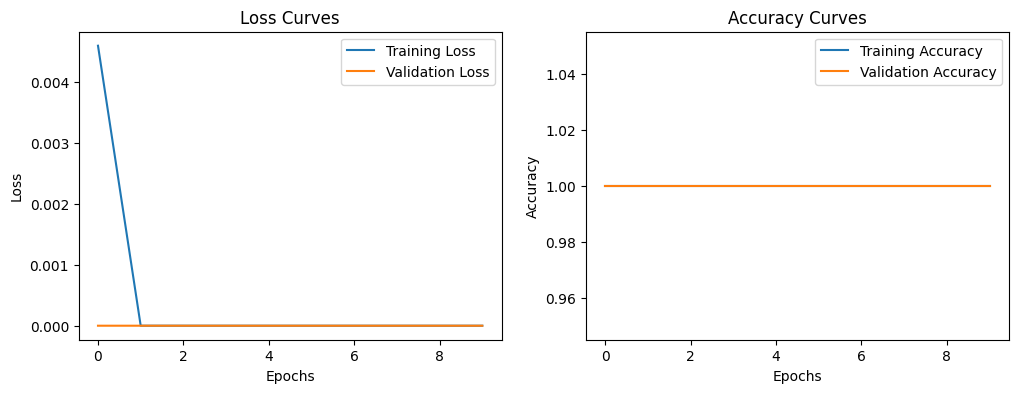

In [27]:
plot_loss_curves(history)